[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Tim-Abwao/machine-learning-with-scikit-learn/HEAD?labpath=2.%20Preprocessing%20Numeric%20Features.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Tim-Abwao/machine-learning-with-scikit-learn/blob/main/2.%20Preprocessing%20Numeric%20Features.ipynb)

# Introduction

Common objectives for preprocessing numeric features include:

### 1. Rescaling

Maps features to a smaller range of values. Large differences in the range of values can negatively impact model performance e.g. in linear models where features with larger values might be considered "more important".

Can be performed with the `StandardScaler`, `MinMaxScaler`, `MaxAbsScaler` and `RobustScaler`. The first 3 are sensitive to outliers, and so `RobustScaler` is often most appropriate.

An additional option is the `Normalizer`, which rescales each example (row) to have unit norm.

### 2. Changing the distribution

Some models have underlying assumptions e.g. that the data is normally distributed. `PowerTransformer` and `QuantileTransformer` can be used to map the data to a desired distribution.

### 3. Discretization / Binning

Some continuous features are more informative when split into discrete "bins" e.g. coordinates (bins could be locations, which are more informative than individual float values). Can be done with the `Binarizer` and `KBinsDiscretizer`.

### 4. Generating polynomial features

Increases complexity of a model (particularly linear models) by adding non-linear features of the input data. Can be achieved with `PolynomialFeatures` and `SplineTransformer`.

---

The *scikit-learn Transformer API* provides the following methods:

- `fit`: compute parameters from training data (e.g. $\mu$ and $\sigma$ for StandardScaler).
- `transform`: convert data.
- `fit_transform`: simultaneously apply the `fit` and `transform` steps above.

To avoid data leakage, `fit` / `fit_transform` are used only on training data, whereas `transform` is used on test data. Or better yet, the entire *Transformer* is added to a preprocessing pipeline.

In the examples below, we'll use `fit_transform` since the goal is solely to demonstrate the effect of the transformations.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sbn
from sklearn.base import TransformerMixin
from sklearn import preprocessing 
from sklearn.datasets import load_wine

# Plot configuration
plt.rc("figure", autolayout=True)
sbn.set_theme(font_scale=0.7, font="serif")

In [2]:
X, y = load_wine(as_frame=True, return_X_y=True)

# Remove column with long name, for clarity in comparative subplots
X = X.drop(columns='od280/od315_of_diluted_wines')

In [3]:
def transform_and_compare(
        transformer: TransformerMixin,
        original_data: pd.DataFrame = X,
        display_transformer_args: bool = True 
    ) -> pd.DataFrame:
    """Apply the `transformer` on the `original_data`, then create histogram
    subplots to compare distributions before and after transformation.

    Args:
        transformer (sklearn.base.TransformerMixin): Numeric preprocessing object.
        original_data (pandas.DataFrame): Data to transform.
        display_transformer_args (bool): Whether or not to display `transformer` args.

    Returns:
        pandas.DataFrame: Transformed data.
    """
    transformed_data = pd.DataFrame(transformer.fit_transform(X),
                                    columns=original_data.columns)
    # Plot values before transformation
    before_axes = original_data.hist(bins=20, layout=(3, 6), figsize=(11, 4))
    before_axes[0, 0].figure.suptitle(f"Before {transformer}", size=18, x=0.2)
    # Plot values after transformation
    after_axes = transformed_data.hist(bins=20, layout=(3, 6), figsize=(11, 4))
    fig = after_axes[0, 0].figure
    fig.suptitle(f"After {transformer}", size=18, x=0.2)

    if display_transformer_args:
        fig.text(0.35, 0.95, f"{transformer.get_params()}")

    return transformed_data

# 1. StandardScaler

Rescales features to have zero mean and unit variance ($\mu = 0$, $\sigma^2 = 1$). Each feature is centered by deducting its mean, then scaled by dividing with its standard deviation:

$$
\bf X_{scaled} = \frac{\bf X - \mu}{\sigma}
$$

Many *scikit-learn* estimators e.g. SVMs (in RBF kernel) and linear models (in Regularizers) expect data that is somewhat standard normally distributed. Features that have significantly higher-magnitude variance might dominate the objective function, and hinder learning from features with low-magnitude variance.

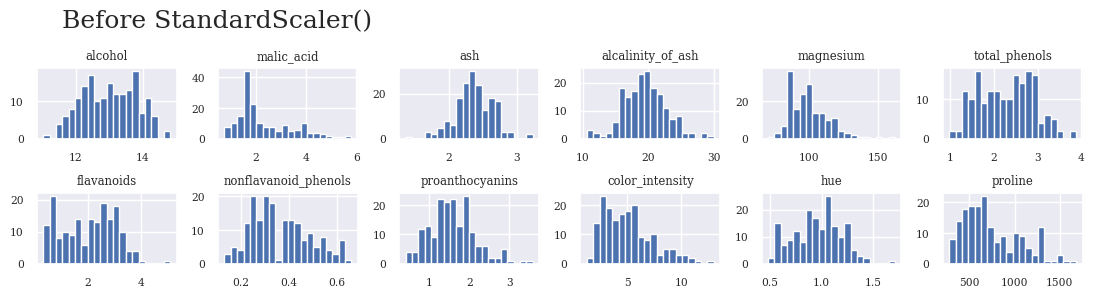

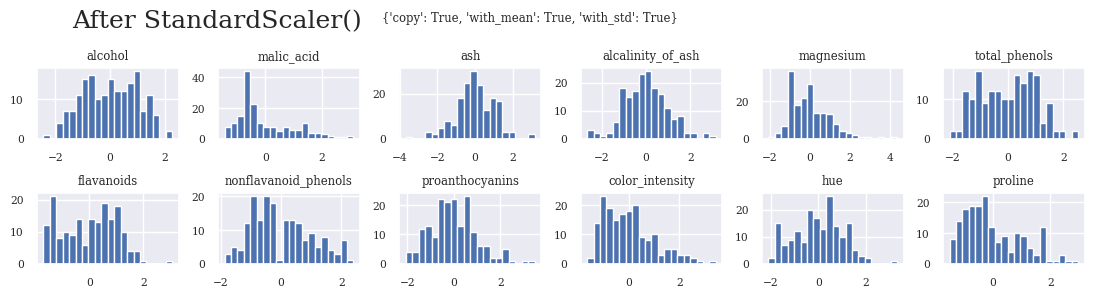

In [4]:
standard_scaler = preprocessing.StandardScaler()
standardized_data = transform_and_compare(transformer=standard_scaler)

>Though features are rescaled to have $\mu = 0$ and $\sigma = 1$, their distributions don't change. 

In [5]:
standardized_data.agg(["mean", "std", "min", "max"]).round(2).T

,mean,std,min,max
alcohol,-0.0,1.0,-2.43,2.26
malic_acid,-0.0,1.0,-1.43,3.11
ash,-0.0,1.0,-3.68,3.16
alcalinity_of_ash,-0.0,1.0,-2.67,3.15
magnesium,-0.0,1.0,-2.09,4.37
total_phenols,0.0,1.0,-2.11,2.54
flavanoids,-0.0,1.0,-1.70,3.06
nonflavanoid_phenols,0.0,1.0,-1.87,2.40
proanthocyanins,-0.0,1.0,-2.07,3.49
color_intensity,0.0,1.0,-1.63,3.44


# 2. MinMaxScaler

Rescales values to lie within a given `feature_range` (default $[0, 1]$).

$$
\bf X_{std} = \frac{\bf X - min(\bf X)}{ max(\bf X) - min(\bf X)}
$$

$$
\bf X_{scaled} = \bf X_{std} \times (b - a) + a
$$

where `feature_range` = $(a, b)$.

Useful for robustness to very small standard deviations.

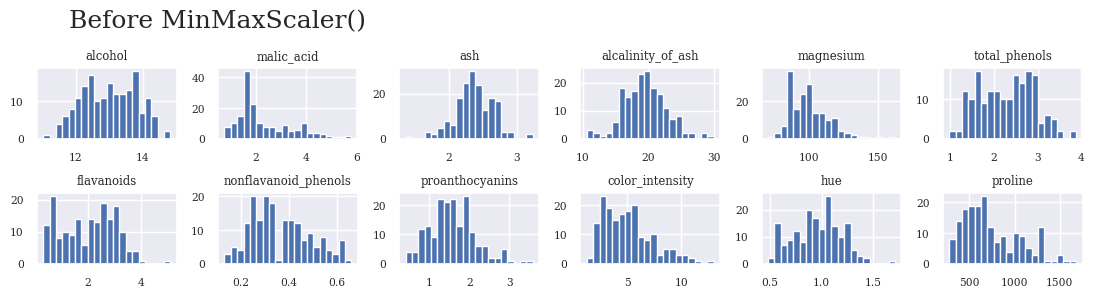

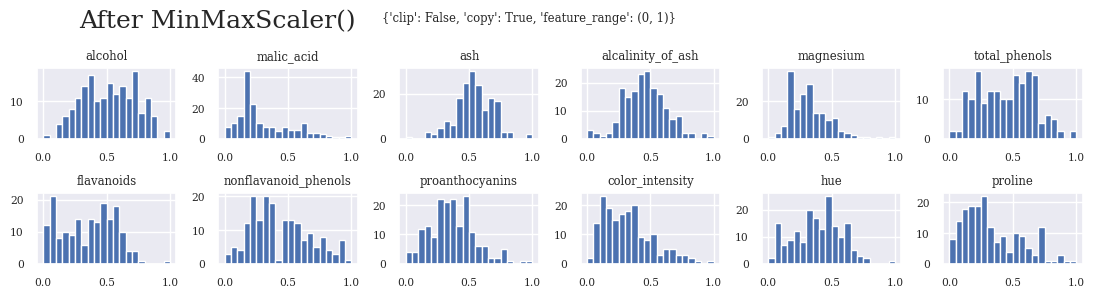

In [6]:
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaled_data = transform_and_compare(transformer=min_max_scaler)

> Though features are rescaled to have $min=0$ and $max=1$, their distributions don't change.

In [7]:
min_max_scaled_data.agg(["mean", "std", "min", "max"]).round(2).T

,mean,std,min,max
alcohol,0.52,0.21,0.0,1.0
malic_acid,0.32,0.22,0.0,1.0
ash,0.54,0.15,0.0,1.0
alcalinity_of_ash,0.46,0.17,0.0,1.0
magnesium,0.32,0.16,0.0,1.0
total_phenols,0.45,0.22,0.0,1.0
flavanoids,0.36,0.21,0.0,1.0
nonflavanoid_phenols,0.44,0.23,0.0,1.0
proanthocyanins,0.37,0.18,0.0,1.0
color_intensity,0.32,0.20,0.0,1.0


# 3. MaxAbsScaler

Rescales values to lie within the range [-1, 1]. Divides each feature by its largest absolute value:

$$
\bf X_{scaled} = \frac{\bf X}{max(|\bf X|)}
$$

Does not shift or center the data, hence preserving sparsity. Meant for data that is already centered at zero or sparse data.

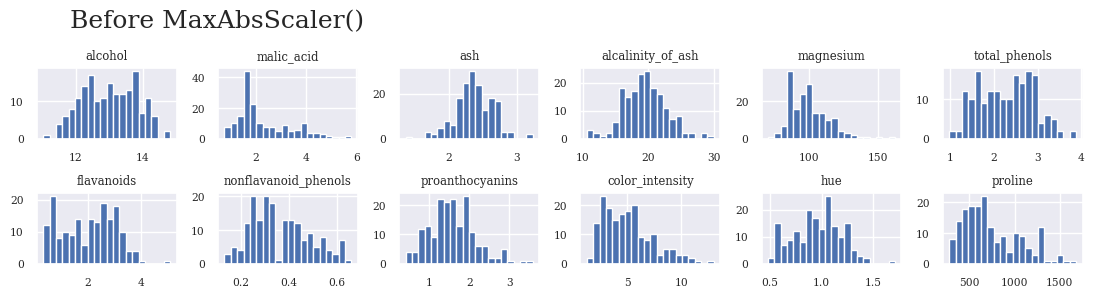

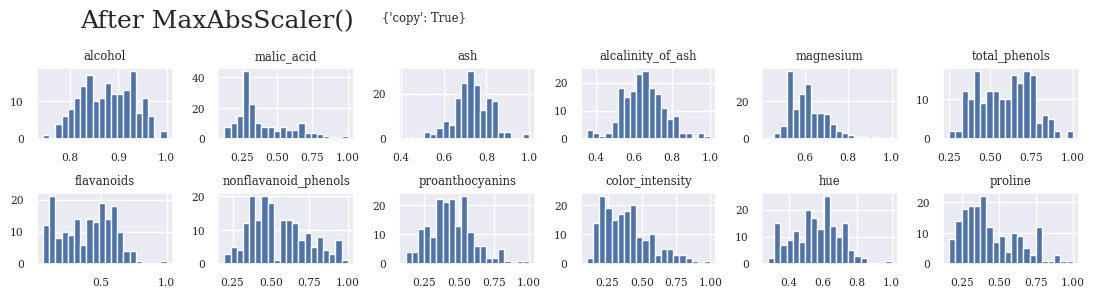

In [8]:
max_absolute_scaler = preprocessing.MaxAbsScaler()
max_absolute_scaled_data = transform_and_compare(transformer=max_absolute_scaler)

>The maximum absolute value for each feature is 1 i.e. $\bf x \in [-1, 1]$. Feature distributions don't change.

In [9]:
max_absolute_scaled_data.agg(["mean", "std", "min", "max"]).round(2).T

,mean,std,min,max
alcohol,0.88,0.05,0.74,1.0
malic_acid,0.40,0.19,0.13,1.0
ash,0.73,0.08,0.42,1.0
alcalinity_of_ash,0.65,0.11,0.35,1.0
magnesium,0.62,0.09,0.43,1.0
total_phenols,0.59,0.16,0.25,1.0
flavanoids,0.40,0.20,0.07,1.0
nonflavanoid_phenols,0.55,0.19,0.20,1.0
proanthocyanins,0.44,0.16,0.11,1.0
color_intensity,0.39,0.18,0.10,1.0


> The sample data above is strictly positive. Here's an additional example with some negative values.
>
> Negative values don't go below -1, and positive values don't exceed 1.

In [10]:
preprocessing.MaxAbsScaler().fit_transform([
    [-4, 5, 3],
    [2.5, 1, 0],
    [-1, -7, 2]
])

array([[-1.        ,  0.71428571,  1.        ],
       [ 0.625     ,  0.14285714,  0.        ],
       [-0.25      , -1.        ,  0.66666667]])

# 4. RobustScaler

Rescales values using quantiles, which are more robust to outliers than $\mu, \sigma$, *max* and *min*. Each feature is centered by deducting the median, and then scaled by dividing with the `quartile_range` (default [IQR](https://en.wikipedia.org/wiki/Interquartile_range)):

$$
\bf X_{scaled} = \frac{\bf X - Q_2}{Q_3 - Q_1}
$$

Useful for features that have extreme outliers.

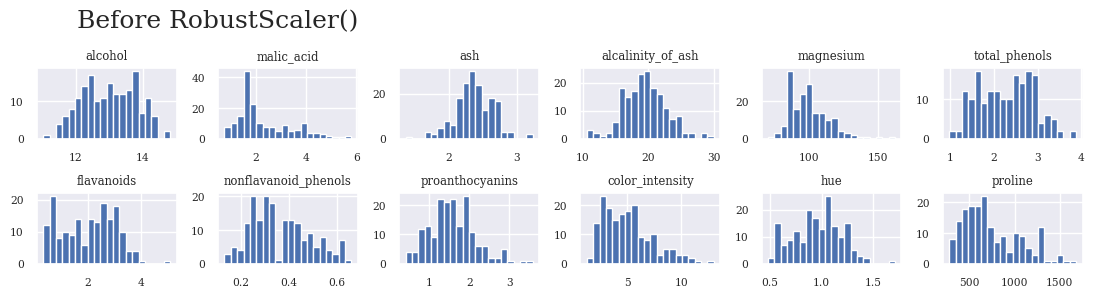

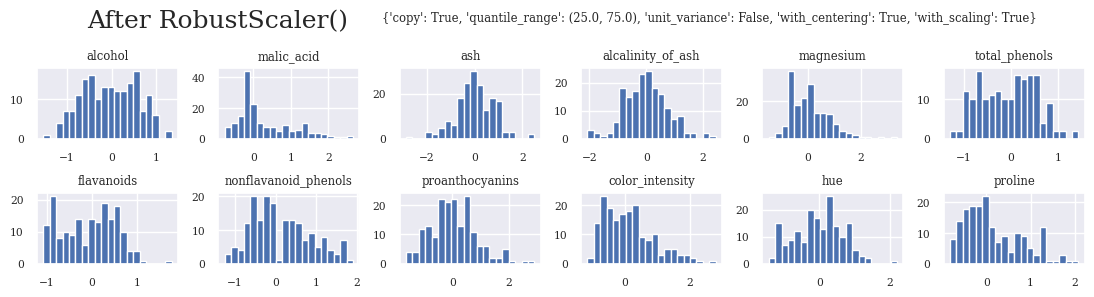

In [11]:
robust_scaler = preprocessing.RobustScaler()
robust_scaled_data = transform_and_compare(robust_scaler)

>Though the features are mapped to a smaller range of values, the distributions don't change.

# 5. Normalizer

Rescales features to have unit norm. Each row in the data is independently scaled such that its norm is 1.

For $L1$:

$$
\bf row_{scaled} = \frac{\bf row}{\bf |row|}
$$

For $L2$:

$$
\bf row_{scaled} = \frac{\bf row}{\bf ||row||}
$$


Useful in text classification or clustering e.g. the dot product of two l2-normalized TF-IDF vectors is the cosine similarity of the vectors.

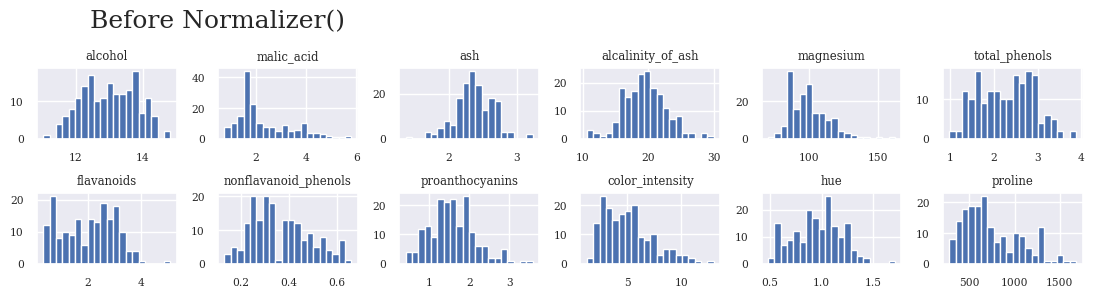

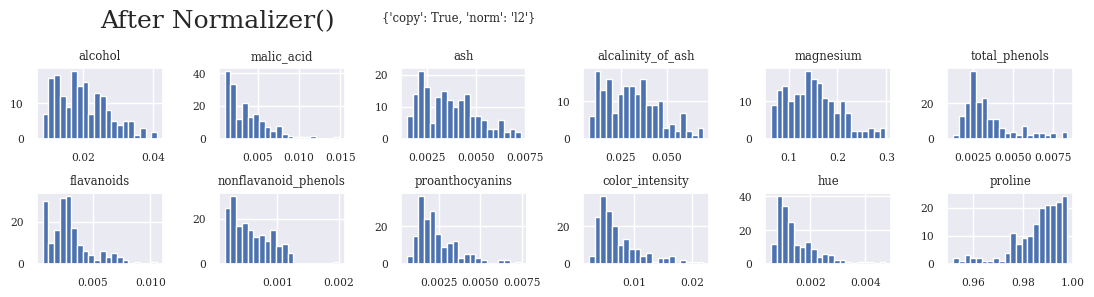

In [12]:
normalizer = preprocessing.Normalizer()
normalized_data_l2 = transform_and_compare(transformer=normalizer)

Feature distributions drastically change. But rows now have unit $L2$ norm.

In [13]:
(normalized_data_l2 ** 2).sum(axis=1)

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
173    1.0
174    1.0
175    1.0
176    1.0
177    1.0
Length: 178, dtype: float64

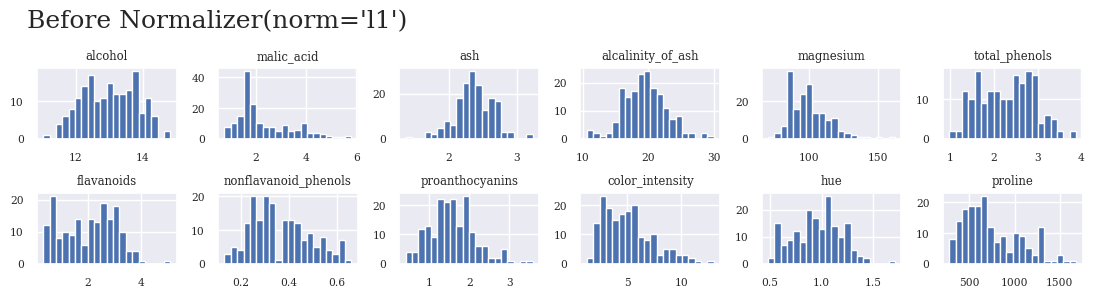

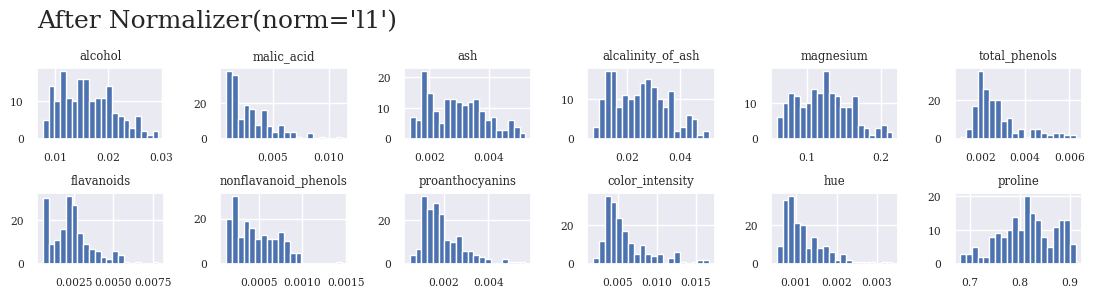

In [14]:
normalizer = preprocessing.Normalizer(norm="l1")
normalized_data_l1 = transform_and_compare(transformer=normalizer,
                                           display_transformer_args=False)

Feature distributions drastically change. But rows now have unit $L1$ norm.

In [15]:
normalized_data_l1.abs().sum(axis=1)

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
173    1.0
174    1.0
175    1.0
176    1.0
177    1.0
Length: 178, dtype: float64

# 6. PowerTransformer

Maps data from any distribution to be as close to a Gaussian (Normal) distribution as possible. Two power transforms are implemented:

- **Yeo-Johnson**: Default.
- **Box-Cox**: Works only on positive values.

Useful for stabilizing variance and minimizing skewness. Normality of features is desirable in many models.

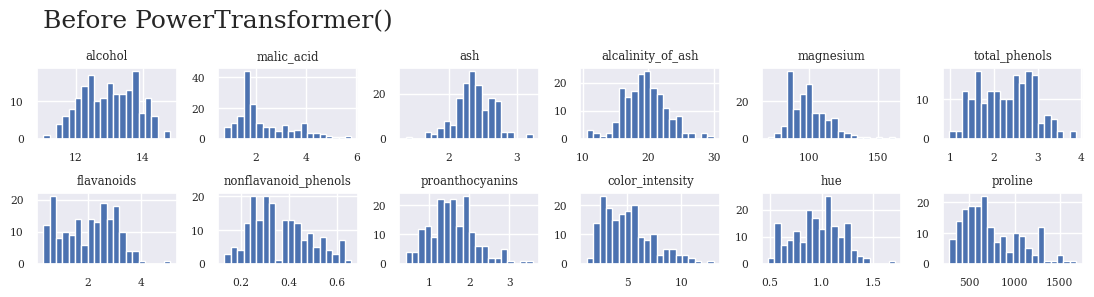

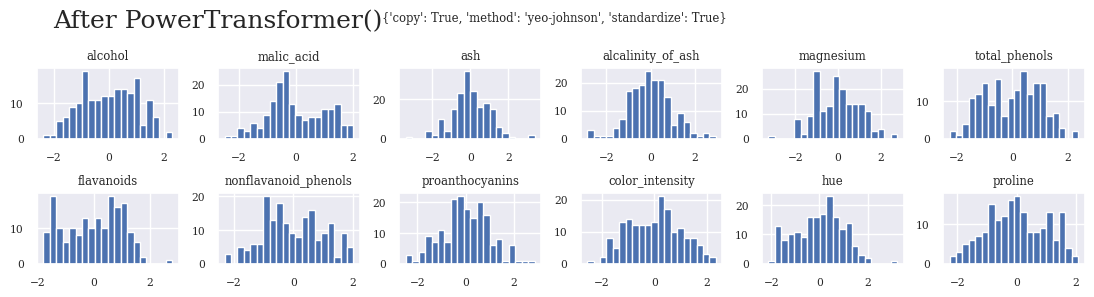

In [16]:
power_transformer = preprocessing.PowerTransformer()
power_transformed_data = transform_and_compare(transformer=power_transformer)

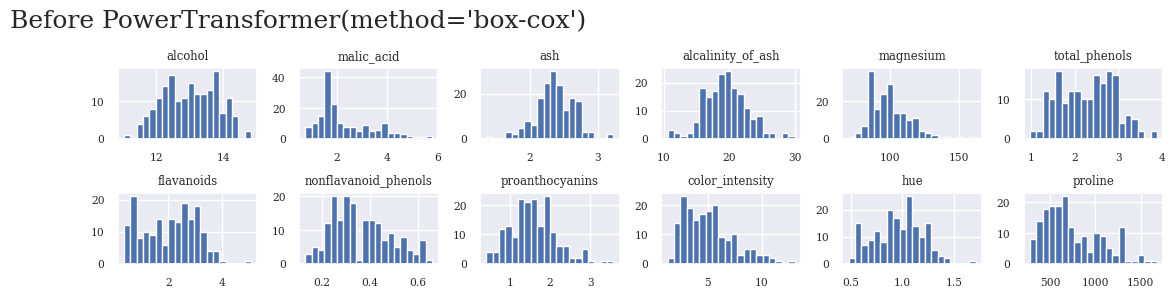

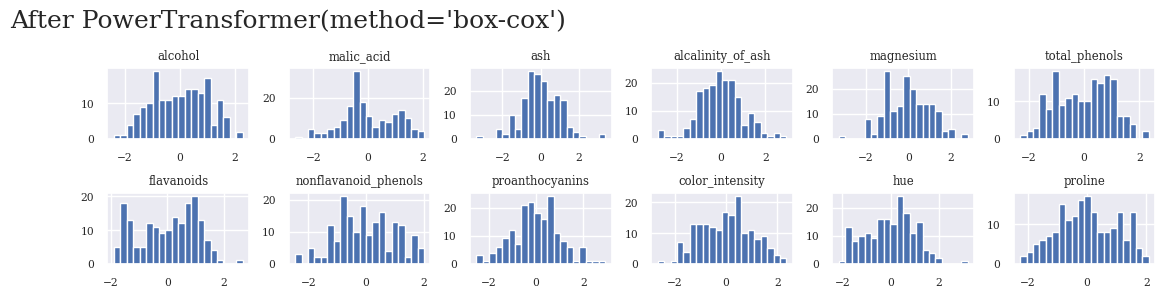

In [17]:
power_transformer = preprocessing.PowerTransformer(method='box-cox')
power_transformed_data = transform_and_compare(transformer=power_transformer,
                                               display_transformer_args=False)

>Feature distributions are made somewhat normal-like. Skewed features e.g.*malic_acid* and *magnesium* are now much less skewed.

In [18]:
power_transformed_data.agg(["mean", "std", "skew"]).round(2).T

,mean,std,skew
alcohol,-0.0,1.0,-0.02
malic_acid,0.0,1.0,0.03
ash,0.0,1.0,0.05
alcalinity_of_ash,0.0,1.0,0.02
magnesium,0.0,1.0,0.01
total_phenols,0.0,1.0,-0.06
flavanoids,-0.0,1.0,-0.19
nonflavanoid_phenols,0.0,1.0,-0.02
proanthocyanins,-0.0,1.0,0.00
color_intensity,0.0,1.0,-0.01


# 7. QuantileTransformer

Uses the formula $G^{-1}(F(X))$ to map features to either

- a uniform distribution with values between 0 and 1 or
- a normal distribution

$F$ is the feature's [cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function) and $G^{-1}$ is the [quantile function](https://en.wikipedia.org/wiki/Quantile_function) of the desired output distribution $G$.

Spreads out most frequent values and reduces the impact of outliers, making it robust.

Non-linear: may distort linear correlations between variables measured at the same scale, and render variables measured at different scales more directly comparable.

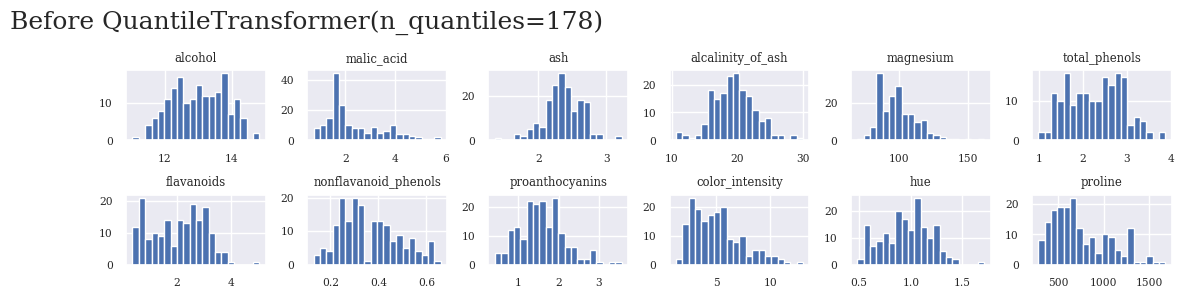

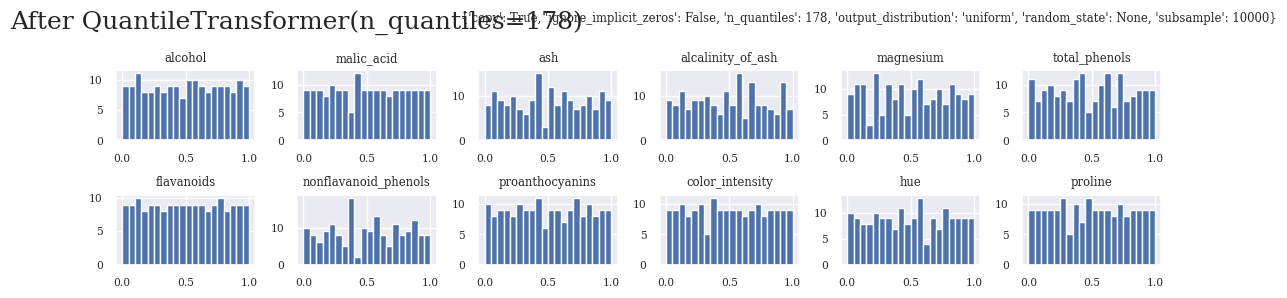

In [19]:
quantile_transformer = preprocessing.QuantileTransformer(n_quantiles=len(X))
quantile_transformed_data = transform_and_compare(transformer=quantile_transformer)

> The default output feature distribution is 'uniform', as can be seen in the 'flat peaks' (equal probability / frequency).

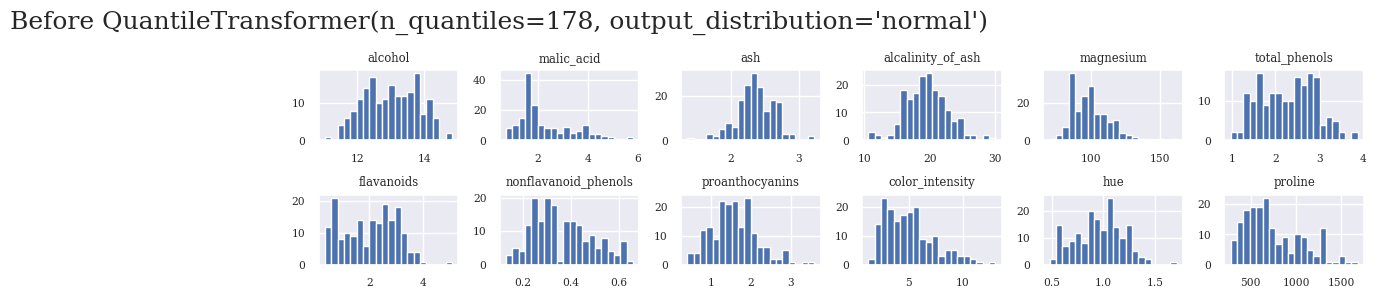

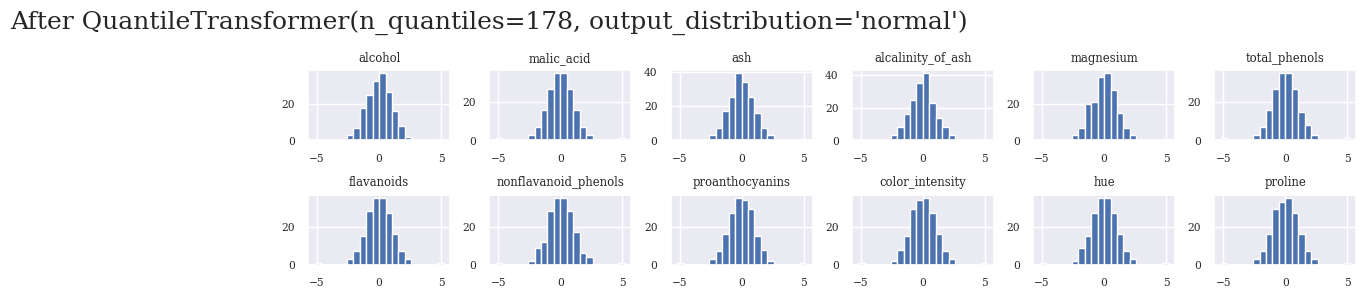

In [20]:
quantile_transformer = preprocessing.QuantileTransformer(n_quantiles=len(X),
                                                         output_distribution="normal")
quantile_transformed_data = transform_and_compare(transformer=quantile_transformer,
                                                  display_transformer_args=False)

> Feature distributions are made normal-like: bell-shaped and symmetrical.

# 8. Binarizer

Applies a `threshold` to numeric values to get binary / boolean values. Values $> threshold$ map to 1, whereas those $\leq threshold$ map to 0.

Useful in text processing when presence / absence of a feature (rather than quantified occurrences) is required.

In [21]:
data = np.array([[-1, 0, 2],
                 [2, -1, 1],
                 [0, -2, 3]])
binarizer = preprocessing.Binarizer(threshold=1)
binarizer.fit_transform(data)

array([[0, 0, 1],
       [1, 0, 0],
       [0, 0, 1]])

# 9. KBinsDiscretizer

Partitions continuous data into discrete values.

The `encode` argument specifies how the transformed result should be encoded:

- *"onehot"*: Use one-hot encoding and return a sparse matrix.
- *"onehot-dense"*: Use one-hot encoding and return a dense array.
- *"ordinal"*: Return the bin identifier encoded as an integer value.

The `strategy` argument specifies bin width:

- *"uniform"*: All bins in each feature have identical widths.
- *"quantile"*: All bins in each feature have the same number of points.
- *"kmeans"*: Values in each bin have the same nearest center of a 1D k-means cluster.


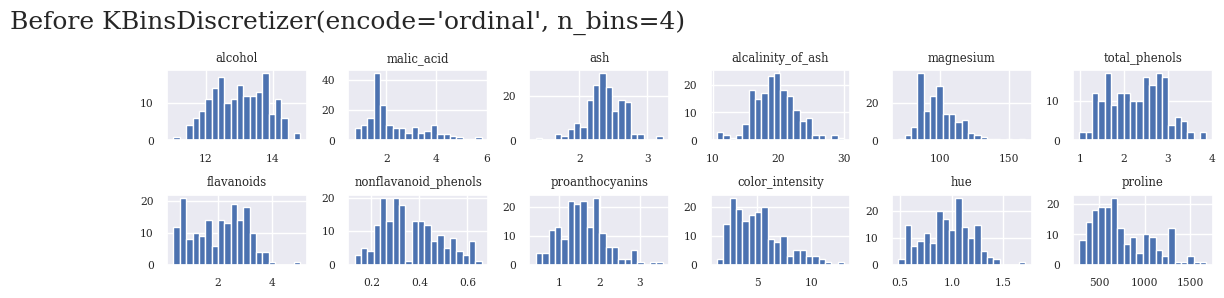

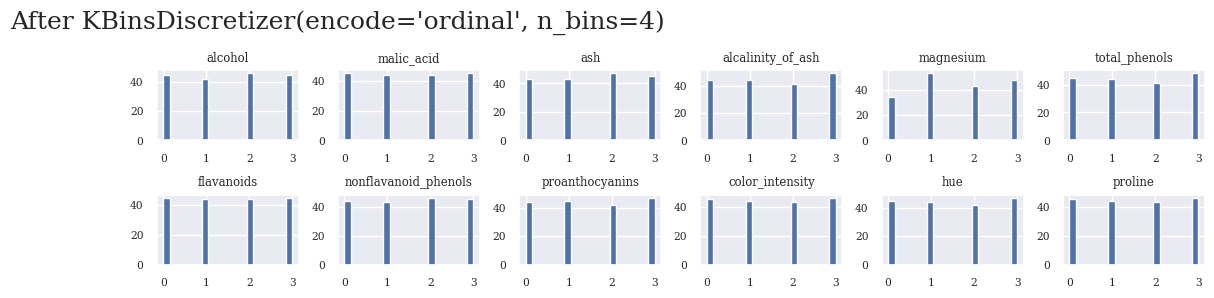

In [22]:
discretizer = preprocessing.KBinsDiscretizer(n_bins=4, encode="ordinal")
discretized_data = transform_and_compare(discretizer,
                                         display_transformer_args=False)

>Features are partitioned into 4 bins.

# 10. PolynomialFeatures

Adds higher-order polynomial and interaction features. Generates a new feature matrix consisting of all polynomial combinations of the features with degree $\leq$ specified `degree` (default 2) e.g.

$$
(X_1, X_2) \Rightarrow (1, X_1, X_2, X_1^2, X_1X_2, X_2^2)
$$

where $degree = 2$.

You can set `interaction_only = True` to produce only interaction terms (default False).

You can set `include_bias = False` to omit the column of ones representing all-zero polynomial powers (default True).

In [23]:
data = np.array([[1, 2],
                 [2, -1],
                 [0, 1]])
polynomial_features = preprocessing.PolynomialFeatures()
pd.DataFrame(polynomial_features.fit_transform(data),
             columns=[1, "$X_1$", "$X_2$", "$X_1^2$", "$X_1X_2$", "$X_2^2$"])

,1,$X_1$,$X_2$,$X_1^2$,$X_1X_2$,$X_2^2$
0,1.0,1.0,2.0,1.0,2.0,4.0
1,1.0,2.0,-1.0,4.0,-2.0,1.0
2,1.0,0.0,1.0,0.0,0.0,1.0


In [24]:
polynomial_features = preprocessing.PolynomialFeatures(include_bias=False,
                                                       interaction_only=True)
pd.DataFrame(polynomial_features.fit_transform(data),
             columns=["$X_1$", "$X_2$", "$X_1X_2$"])

,$X_1$,$X_2$,$X_1X_2$
0,1.0,2.0,2.0
1,2.0,-1.0,-2.0
2,0.0,1.0,0.0


# 11. SplineTransformer

Generates spline basis functions ([B-splines](https://en.wikipedia.org/wiki/B-spline)) for each feature independently, thus no interaction terms are produced.

Advantages of splines over polynomials:

- Very flexible and robust if you keep a fixed low degree (usually 3), and parsimoniously adapt the number of knots.
- Do not have oscillatory behaviour at the boundaries as have polynomials ([Runge’s phenomenon](https://en.wikipedia.org/wiki/Runge%27s_phenomenon)).
- Provide good options for extrapolation beyond the boundaries.

High degrees and a high number of knots can cause overfitting.

In [25]:
data = np.array([[1, 2],
                 [2, -1],
                 [0, 1]])
spline_transformer = preprocessing.SplineTransformer()
spline_transformer.fit_transform(X)

array([[0.        , 0.        , 0.        , ..., 0.31206437, 0.00246195,
        0.        ],
       [0.        , 0.        , 0.061123  , ..., 0.28431134, 0.00138535,
        0.        ],
       [0.        , 0.        , 0.07255635, ..., 0.5317372 , 0.03383657,
        0.        ],
       ...,
       [0.        , 0.        , 0.04412324, ..., 0.03408355, 0.        ,
        0.        ],
       [0.        , 0.        , 0.06957496, ..., 0.03661979, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])